# Public Visualization Notebook

This notebook demonstrates:
- Loading preprocessed artifacts (no raw data needed)
- Visualizing sample images
- Class distribution analysis (BEFORE BALANCING)

**No private preprocessing logic is required to run this notebook.**

In [1]:
# Add parent directory to path for imports
import sys, os
sys.path.append(os.path.abspath(".."))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import json
from matplotlib.gridspec import GridSpec

# Import model and explainability modules
from src.model_trigconv2d import create_trigconv2d_model
from src.explainability import grad_cam, integrated_gradients

## Load Artifacts

Load preprocessed sample data from the artifacts folder.

In [3]:
# Load sample artifacts
X_sample = np.load("../artifacts/X_test_sample.npy")
y_sample = np.load("../artifacts/y_test_sample.npy")
label_names = np.load("../artifacts/label_names.npy")

print(f"Loaded X_sample: {X_sample.shape}")
print(f"Loaded y_sample: {y_sample.shape}")
print(f"Label names: {label_names}")
print(f"Number of classes: {len(label_names)}")

Loaded X_sample: (100, 128, 128, 3)
Loaded y_sample: (100, 6)
Label names: ['Benign' 'Glioma Tumor' 'Malignant' 'Meningioma Tumor' 'No Tumor'
 'Pituitary Tumor']
Number of classes: 6


## Visualize Sample Images

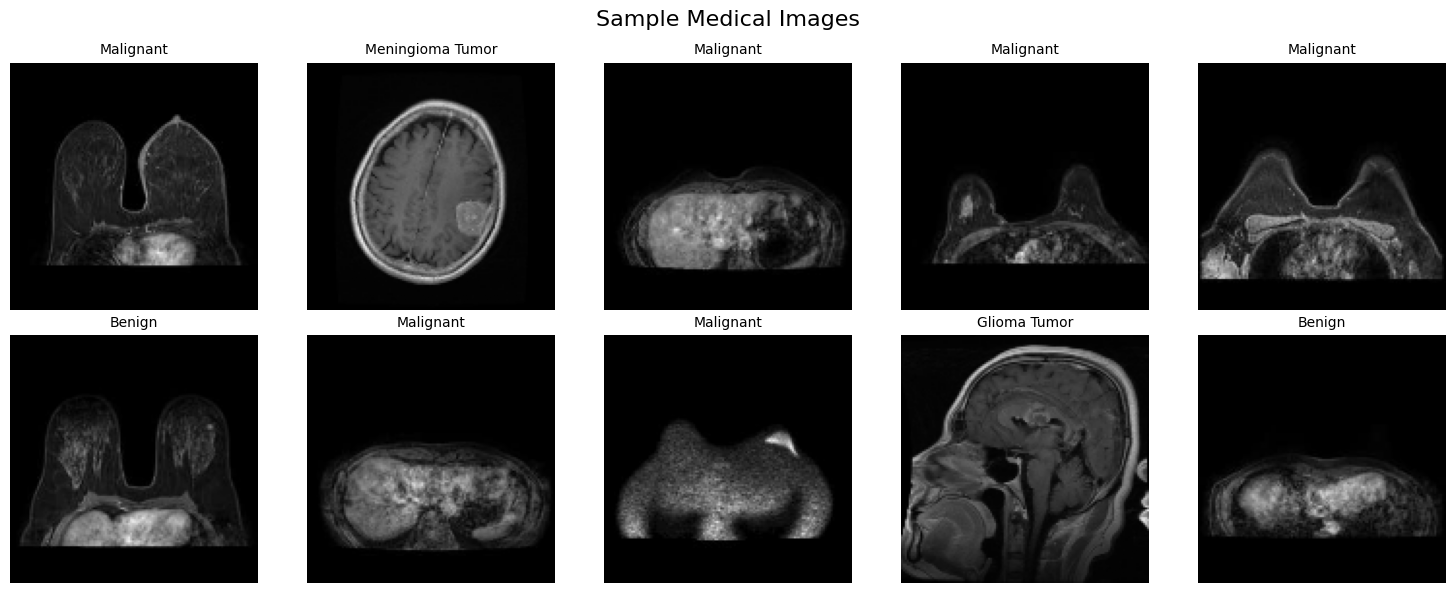

In [4]:
# Display a grid of sample images with their labels
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Sample Medical Images', fontsize=16)

for idx, ax in enumerate(axes.flat):
    if idx < len(X_sample):
        # Get image and true label
        img = X_sample[idx]
        true_label_idx = np.argmax(y_sample[idx])
        true_label = label_names[true_label_idx]
        
        # Display image (assuming grayscale or RGB)
        if img.shape[-1] == 1:
            ax.imshow(img.squeeze(), cmap='gray')
        else:
            ax.imshow(img)
        
        ax.set_title(f'{true_label}', fontsize=10)
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

## Class Distribution (BEFORE BALANCING)

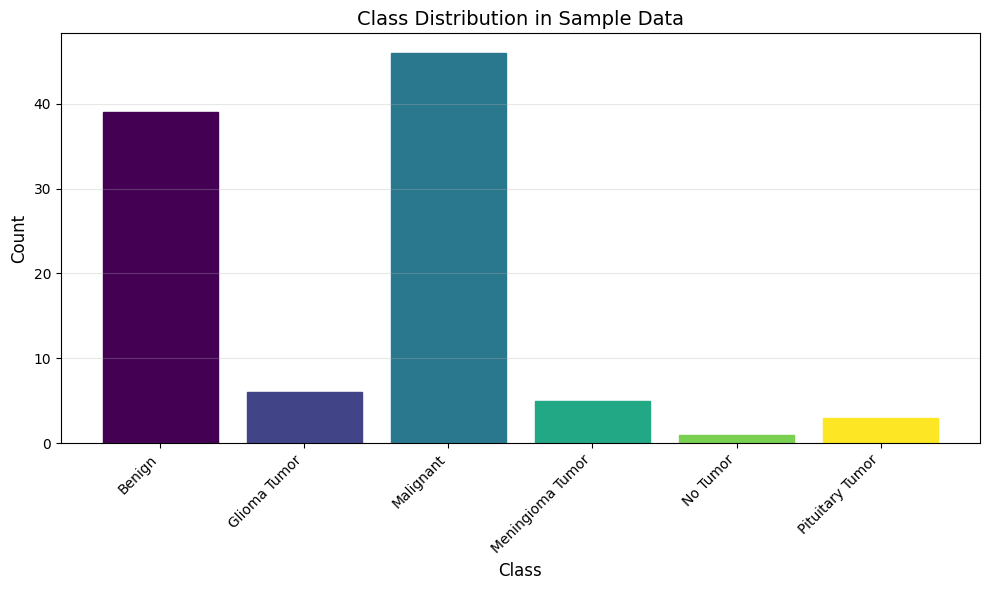

Class distribution:
  Benign: 39 (39.0%)
  Glioma Tumor: 6 (6.0%)
  Malignant: 46 (46.0%)
  Meningioma Tumor: 5 (5.0%)
  No Tumor: 1 (1.0%)
  Pituitary Tumor: 3 (3.0%)


In [5]:
# Analyze class distribution in the sample
class_counts = np.sum(y_sample, axis=0)

plt.figure(figsize=(10, 6))
bars = plt.bar(label_names, class_counts)

# Color bars
colors = plt.cm.viridis(np.linspace(0, 1, len(label_names)))
for bar, color in zip(bars, colors):
    bar.set_color(color)

plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Class Distribution in Sample Data', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Print statistics
print("Class distribution:")
for label, count in zip(label_names, class_counts):
    print(f"  {label}: {int(count)} ({count/len(y_sample)*100:.1f}%)")

## Load Model

Load the trained model (either from .keras file or recreate architecture).

In [7]:
# Load the trained model with custom TrigConv2D layer
import tensorflow as tf
from src.model_trigconv2d import TrigConv2D

model = tf.keras.models.load_model(
    r"C:\Users\vihar\OneDrive\Desktop\Projects\Medical Imaging Project\Load_datasets\best_model.keras",
    custom_objects={'TrigConv2D': TrigConv2D}
)
print("✅ Model loaded successfully!")
model.summary()


✅ Model loaded successfully!


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ trig_conv2d (TrigConv2D)        │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30752)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,968,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,919,668 (22.58 MB)

 Trainable params: 1,973,222 (7.53 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,946,446 (15.05 MB)

## Model Predictions

Generate predictions on sample data.

In [8]:
# Get predictions
predictions = model.predict(X_sample)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_sample, axis=1)

# Calculate accuracy
accuracy = np.mean(predicted_classes == true_classes)
print(f"Sample accuracy: {accuracy*100:.2f}%")

# Show some predictions
print("\nSample predictions:")
for i in range(min(10, len(X_sample))):
    true_label = label_names[true_classes[i]]
    pred_label = label_names[predicted_classes[i]]
    confidence = predictions[i][predicted_classes[i]]
    match = "✓" if true_classes[i] == predicted_classes[i] else "✗"
    print(f"  [{match}] True: {true_label:20s} | Predicted: {pred_label:20s} (confidence: {confidence:.3f})")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Sample accuracy: 99.00%

Sample predictions:
  [✓] True: Malignant            | Predicted: Malignant            (confidence: 1.000)
  [✓] True: Meningioma Tumor     | Predicted: Meningioma Tumor     (confidence: 0.999)
  [✓] True: Malignant            | Predicted: Malignant            (confidence: 1.000)
  [✓] True: Malignant            | Predicted: Malignant            (confidence: 1.000)
  [✓] True: Malignant            | Predicted: Malignant            (confidence: 1.000)
  [✓] True: Benign               | Predicted: Benign               (confidence: 1.000)
  [✓] True: Malignant            | Predicted: Malignant            (confidence: 1.000)
  [✓] True: Malignant            | Predicted: Malignant            (confidence: 0.991)
  [✓] True: Glioma Tumor         | Predicted: Glioma Tumor         (confidence: 0.997)
  [✓] True: Benign               | Predicted: Benign               (confidence: 0.997)


## Summary

This notebook demonstrates that:
- ✅ Preprocessed artifacts can be loaded without raw data access
- ✅ Model architecture and weights are functional
- ✅ Explainability techniques (Grad-CAM, Integrated Gradients) provide insights
- ✅ No private preprocessing logic is required

All visualizations prove the legitimacy of the ML pipeline while keeping private code protected.